In [2]:
from pathlib import Path
from typing import List

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import torch
import xgboost as xgb
from PIL import Image
from numpy.typing import NDArray
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
from umap import UMAP

In [3]:
def project_vectors(data: NDArray, technique: str = "tsne", **options) -> NDArray:
    if technique == "pca":
        transformer = PCA(**options)
    elif technique == "tsne":
        transformer = TSNE(**options)
    elif technique == "umap":
        transformer = UMAP(**options)
    else:
        raise ValueError(
            f"Invalid technique: {technique}. Choose from 'pca', 'tsne', or 'umap'."
        )

    transformed_data = transformer.fit_transform(data)
    return transformed_data

In [4]:
pio.renderers.default = "browser"
print(torch.cuda.is_available())

True


In [5]:
path = kagglehub.dataset_download("prasunroy/natural-images")

path = Path(path)
print("Path to dataset files:", path)

Path to dataset files: C:\Users\miknowak\.cache\kagglehub\datasets\prasunroy\natural-images\versions\1


In [6]:
paths_to_images = list(path.glob("**/*.jpg"))
print("Number of images:", len(paths_to_images))
assert len(paths_to_images) > 0, "No images found in the dataset."

Number of images: 13798


In [7]:
path_df = pd.DataFrame(paths_to_images, columns=["path"])
path_df['class'] = path_df['path'].apply(lambda x: x.parent.name)
path_df['class'] = path_df['class'].astype("category")
path_df = path_df.sample(n=600).reset_index(drop=True)
path_df

,path,class
0,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,dog
1,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,motorbike
2,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,motorbike
3,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,cat
4,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,fruit
...,...,...
595,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,flower
596,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,fruit
597,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,flower
598,C:\Users\miknowak\.cache\kagglehub\datasets\prasu...,airplane


In [11]:
def generate_image_embeddings_with_dinov2(
        image_paths: list[str | Path],
        model_name: str = "facebook/dinov2-base",
        batch_size: int = 1
) -> np.ndarray:
    """
    Generate embeddings for a batch of images using a pretrained DINOv2 model with CUDA support.

    Args:
        image_paths (List[str | Path]): List of image file paths.
        model_name (str): Name of the pretrained model to use. Default is "facebook/dinov2-base".
        batch_size (int): Number of images to process per batch. Default is 1.

    Returns:
        np.ndarray: 2D array of image embedding vectors (num_images, embedding_dim).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    all_embeddings = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        images = [Image.open(path).convert("RGB") for path in batch_paths]

        inputs = processor(images=images, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # DINOv2 outputs `last_hidden_state` (batch_size, seq_len, hidden_dim)
        # We mean-pool over the sequence (excluding the [CLS] token if present)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings).squeeze()


embeddings = generate_image_embeddings_with_dinov2(path_df.path.tolist(), batch_size=16,
                                                   model_name="facebook/dinov2-base")

Using device: cuda


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


In [9]:
embeddings.shape

(600, 768)

In [10]:
def generate_image_embeddings_as_histograms(image_paths: list[str | Path]):
    """
    Generate embeddings for an image using a pretrained model from HuggingFace.
    
    Args:
        image_paths (list[str | Path]): List of image file paths.
    
    Returns:
        numpy.ndarray: Image embeddings matrix of shape (num_images, 256).
    """
    histograms = []
    for image_path in tqdm(image_paths):
        image = Image.open(image_path)
        image = image.resize((224, 224))

        # Convert image to numpy array
        image = np.array(image)

        # Create histogram
        histogram, _ = np.histogram(image, bins=256, range=(0, 256))
        histograms.append(histogram)

    return np.vstack(histograms).squeeze()


embeddings = generate_image_embeddings_as_histograms(path_df.path.tolist())

100%|██████████| 600/600 [00:01<00:00, 544.16it/s]


In [13]:
def plot_embeddings(embeddings: NDArray,
                    additional_columns: dict[str, list[any]] = None,
                    map_columns_as_categories: list[str] = None,
                    reduce_technique: str = "tsne",
                    symbol: str = None,
                    color: str = None,
                    hover_data: list[str] = None,
                    plot_3d: bool = False
                    ):
    if additional_columns is None:
        additional_columns = {}

    for column_name, column_data in additional_columns.items():
        if len(column_data) != embeddings.shape[0]:
            raise ValueError(f"Length of column data for '{column_name}' does not match number of embeddings.")

    for on_hover_column_name in hover_data:
        if on_hover_column_name not in additional_columns:
            raise ValueError(f"Column '{on_hover_column_name}' not found in additional columns.")

    
    if embeddings.shape[1] > 2:
        reduced_embeddings = project_vectors(embeddings, technique=reduce_technique,
                                             n_components=3 if plot_3d else 2, random_state=6)
        print(f"Reduced embeddings from {embeddings.shape[1]} to {reduced_embeddings.shape[1]}")
    else:
        reduced_embeddings = embeddings
        
    df = pd.DataFrame({
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],

        "z": reduced_embeddings[:, 2] if plot_3d else None,

        **additional_columns
    })

    df = df.astype(
        {col: "category" for col in df.select_dtypes(include=["object", "category"]).columns}
    )
    
    
    
    if map_columns_as_categories is not None:
        df = df.astype(
            {col: "category" for col in map_columns_as_categories}
        )

    if plot_3d:
        fig = px.scatter_3d(df, x="x", y="y", z="z", color=color, symbol=symbol,
                            title=f"{reduce_technique} reduction technique. Visualization of Image Embeddings",
                            hover_data=hover_data)
    else:
        fig = px.scatter(df, x="x", y="y", color=color, symbol=symbol,
                         title=f"{reduce_technique} reduction technique. Visualization of Image Embeddings",
                         hover_data=hover_data
                         
                         
                         )

    fig.update_traces(textfont_size=25, marker=dict(size=25))
    fig.update_layout(template="plotly")
    fig.show()


plot_embeddings(embeddings,
                additional_columns={
                    "class": path_df["class"].tolist(),
                    "path": list(map(lambda d: str(d), path_df["path"].tolist())),
                },
                color="class",
                hover_data=["path", "class"],
                plot_3d=False,
                reduce_technique="tsne"
                )

Reduced embeddings from 768 to 2


In [22]:
# Convert labels to numerical values
unique_labels = path_df["class"].unique()
# print("Unique labels:", unique_labels)
label_mapping  = {label: idx for idx, label in enumerate(unique_labels)}
labels = path_df["class"].map(label_mapping)
reverse_label_mapping = { value:key for key, value in label_mapping.items()}
label_mapping

{'dog': 0,
 'motorbike': 1,
 'cat': 2,
 'fruit': 3,
 'car': 4,
 'airplane': 5,
 'flower': 6,
 'person': 7}

Training data shape: (420, 768)
Testing data shape: (180, 768)
F1 Score: 0.9884

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        24
           3       0.92      1.00      0.96        24
           4       1.00      1.00      1.00        29
           5       1.00      1.00      1.00        23
           6       1.00      0.90      0.95        20
           7       1.00      1.00      1.00        24

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



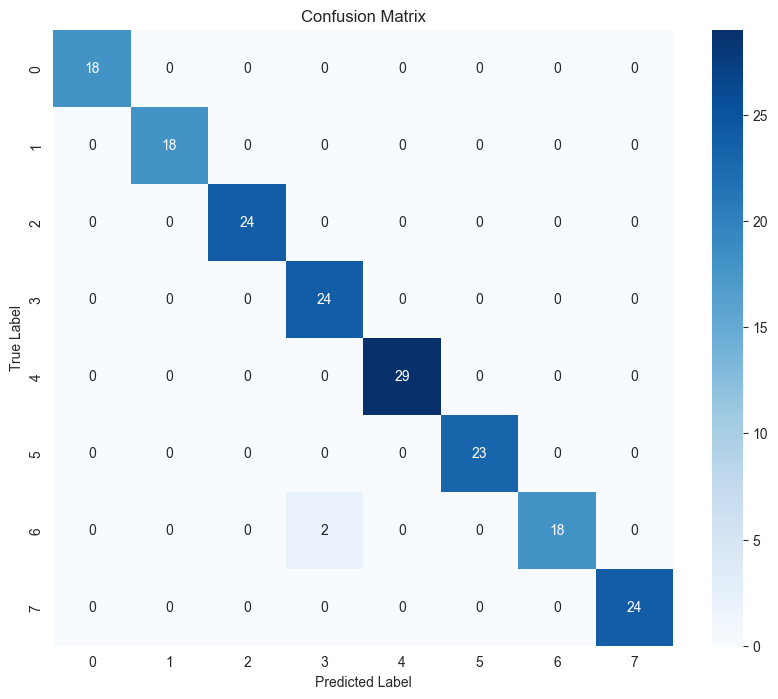

In [15]:
# reduced_embeddings = project_vectors(embeddings, 
#                                      technique="pca", 
#                                      n_components=2, random_state=6)

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.3, stratify=labels, shuffle=True
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softprob', 
    eval_metric='mlogloss',
    random_state=42
)

xgb_clf.fit(X_train, y_train)


y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)

accuracy = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(768,)
We need to add one dimension: (1, 768)
Predicted class idx: 0
Predicted class name: dog


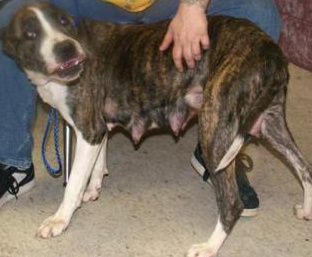

In [23]:
# Visualize one prediction
example_idx = 0
example_image_path = path_df.iloc[example_idx]["path"]
example_image_embedding = embeddings[example_idx]
print(example_image_embedding.shape)
print("We need to add one dimension:", example_image_embedding.reshape(1, -1).shape)
y_pred = xgb_clf.predict(example_image_embedding.reshape(1, -1))
print("Predicted class idx:", y_pred[0])
print("Predicted class name:", reverse_label_mapping[y_pred[0].item()])
Image.open(example_image_path)

Training data shape: (420, 768)
Testing data shape: (180, 768)
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        29
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        24

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



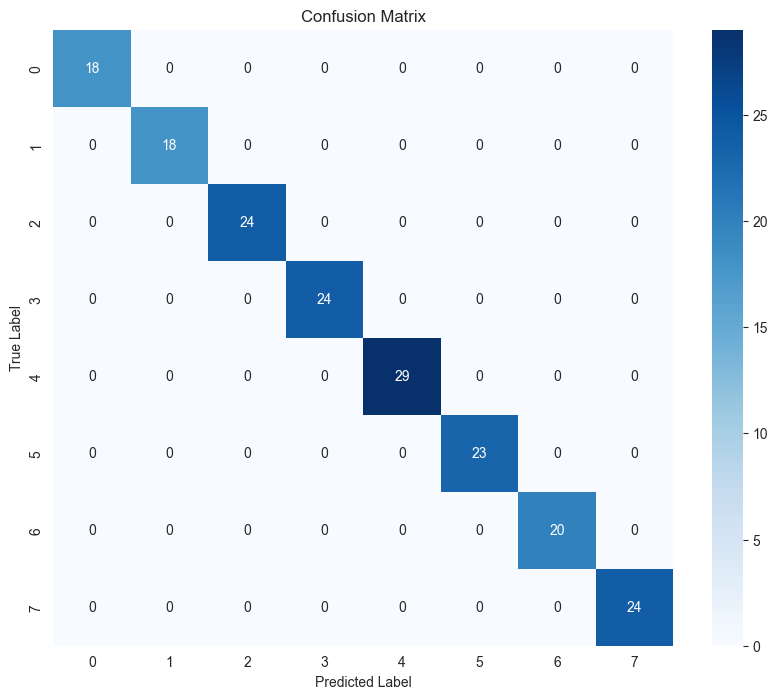

In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.3, stratify=labels, shuffle=True
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)  # You can tune this value
knn_clf.fit(X_train, y_train)

# Predict
y_pred = knn_clf.predict(X_test)
y_pred_proba = knn_clf.predict_proba(X_test)

# Evaluation
accuracy = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

We need to add one dimension: (1, 768)
Predicted class idx: 1
Predicted class name: motorbike


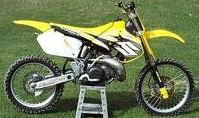

In [27]:
# Visualize one prediction
example_idx = 26
example_image_path = path_df.iloc[example_idx]["path"]
example_image_embedding = embeddings[example_idx]
print("We need to add one dimension:", example_image_embedding.reshape(1, -1).shape)
y_pred = knn_clf.predict(example_image_embedding.reshape(1, -1))
print("Predicted class idx:", y_pred[0])
print("Predicted class name:", reverse_label_mapping[y_pred[0].item()])
Image.open(example_image_path)

In [22]:
def cluster_embeddings(embeddings: NDArray, algorithm_name: str = 'KMeans', **kwargs):
    """
    Clusters embeddings using a specified clustering algorithm from sklearn.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embeddings to cluster, shape (n_samples, n_features)
    algorithm_name : str
        Name of the clustering algorithm to use (must be available in sklearn.cluster
        or be GaussianMixture)
    **kwargs : 
        Additional parameters to pass to the clustering algorithm
        
    Returns:
    --------
    labels : numpy.ndarray
        Cluster labels for each embedding, shape (n_samples,)
    model : object
        The fitted clustering model
    """
    if not isinstance(embeddings, np.ndarray):
        raise TypeError("Embeddings must be a numpy array")

    if len(embeddings.shape) != 2:
        raise ValueError(f"Embeddings must be 2D array, got shape {embeddings.shape}")

    if algorithm_name == 'GaussianMixture':
        algorithm_class = GaussianMixture
    else:
        try:
            algorithm_class = getattr(cluster, algorithm_name)
        except AttributeError:
            raise ValueError(f"Algorithm '{algorithm_name}' not found in sklearn.cluster or is not GaussianMixture")

    model = algorithm_class(**kwargs)

    if hasattr(model, 'fit_predict'):
        labels = model.fit_predict(embeddings)
    elif hasattr(model, 'fit') and hasattr(model, 'predict'):

        model.fit(embeddings)
        labels = model.predict(embeddings)
    else:
        raise ValueError(f"Algorithm '{algorithm_name}' does not support required methods")

    return labels, model


In [25]:
clustering_results, model1 = cluster_embeddings(embeddings, 'KMeans', n_clusters=7)
print(f"KMeans labels shape: {clustering_results.shape}, unique clusters: {np.unique(clustering_results)}")

plot_embeddings(embeddings,
                additional_columns={
                    "class": path_df["class"].tolist(),
                    "path": list(map(str, path_df["path"].tolist())),
                    # "path": path_df["path"].tolist(),
                    "cluster": clustering_results.tolist()
                },
                color="cluster",
                symbol="class",
                hover_data=["path"],
                map_columns_as_categories=["cluster"]
                )

KMeans labels shape: (600,), unique clusters: [0 1 2 3 4 5 6]
Reduced embeddings from 768 to 2


In [26]:
adjusted_rand_score(clustering_results, labels)

0.9094667415623424

In [27]:
clustering_results

array([6, 1, 1, 1, 4, 2, 6, 5, 1, 2, 3, 1, 3, 1, 4, 1, 4, 5, 1, 0, 5, 1,
       6, 4, 0, 5, 6, 1, 1, 4, 1, 6, 3, 1, 6, 4, 2, 0, 6, 1, 0, 4, 4, 0,
       3, 3, 3, 3, 3, 1, 0, 5, 0, 3, 6, 1, 6, 5, 5, 0, 0, 5, 1, 1, 6, 1,
       1, 6, 2, 4, 4, 4, 6, 3, 3, 1, 5, 1, 1, 0, 2, 4, 2, 5, 3, 5, 4, 5,
       6, 3, 0, 2, 1, 2, 5, 6, 1, 3, 2, 0, 1, 6, 6, 1, 6, 5, 6, 1, 5, 4,
       2, 5, 0, 5, 3, 3, 3, 5, 5, 6, 4, 1, 6, 5, 2, 6, 0, 1, 2, 1, 1, 1,
       0, 5, 2, 3, 4, 3, 5, 0, 2, 3, 5, 6, 2, 0, 1, 4, 5, 4, 5, 0, 1, 6,
       1, 6, 5, 0, 6, 1, 4, 3, 5, 5, 4, 6, 1, 1, 0, 2, 1, 1, 1, 0, 0, 4,
       5, 6, 0, 3, 6, 6, 2, 1, 5, 5, 5, 3, 6, 6, 5, 4, 0, 5, 6, 1, 2, 6,
       0, 0, 0, 6, 3, 3, 0, 2, 5, 0, 3, 2, 5, 5, 5, 5, 3, 1, 2, 6, 1, 4,
       1, 1, 1, 3, 3, 5, 1, 2, 1, 5, 1, 1, 5, 6, 3, 4, 4, 2, 2, 5, 0, 1,
       5, 3, 4, 6, 6, 2, 5, 2, 3, 4, 5, 4, 0, 5, 2, 3, 6, 6, 1, 6, 2, 6,
       4, 1, 4, 6, 5, 6, 2, 1, 3, 1, 0, 6, 6, 1, 3, 3, 0, 5, 1, 4, 6, 0,
       2, 6, 4, 6, 4, 3, 2, 3, 6, 2, 3, 0, 5, 4, 3,

PC1: 0.1393 (0.1393 cumulative)
PC2: 0.1006 (0.2398 cumulative)
PC3: 0.0903 (0.3301 cumulative)
PC4: 0.0710 (0.4012 cumulative)
PC5: 0.0664 (0.4676 cumulative)
PC6: 0.0516 (0.5192 cumulative)
PC7: 0.0213 (0.5405 cumulative)
PC8: 0.0152 (0.5557 cumulative)
PC9: 0.0147 (0.5704 cumulative)
PC10: 0.0126 (0.5830 cumulative)
PC11: 0.0112 (0.5942 cumulative)
PC12: 0.0104 (0.6046 cumulative)
PC13: 0.0094 (0.6140 cumulative)
PC14: 0.0090 (0.6230 cumulative)
PC15: 0.0084 (0.6313 cumulative)
PC16: 0.0080 (0.6394 cumulative)
PC17: 0.0077 (0.6471 cumulative)
PC18: 0.0075 (0.6546 cumulative)
PC19: 0.0072 (0.6618 cumulative)
PC20: 0.0069 (0.6687 cumulative)
PC21: 0.0064 (0.6751 cumulative)
PC22: 0.0064 (0.6816 cumulative)
PC23: 0.0062 (0.6878 cumulative)
PC24: 0.0060 (0.6938 cumulative)
PC25: 0.0059 (0.6996 cumulative)
PC26: 0.0056 (0.7052 cumulative)
PC27: 0.0053 (0.7106 cumulative)
PC28: 0.0051 (0.7157 cumulative)
PC29: 0.0049 (0.7206 cumulative)
PC30: 0.0048 (0.7254 cumulative)
PC31: 0.0047 (0.730

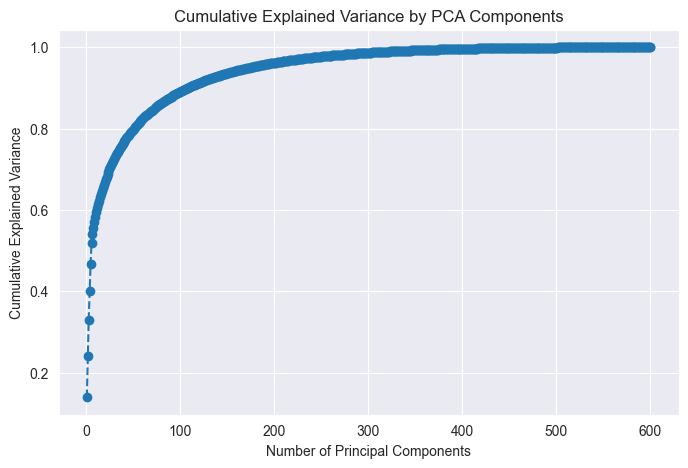

In [30]:
pca = PCA()
X_pca = pca.fit_transform(embeddings)

# Step 3: Variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print results
for i, (ev, cum) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"PC{i+1}: {ev:.4f} ({cum:.4f} cumulative)")

# Optional: Plot variance explained
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()